In [2]:
 """ Testing color deconvolution on various images types and test method sensitivity

Usage:
======
    1. Test a new dataset with very variable lightness and resolution conditions in copepods images [X]
    2. Try to compare results to a "ground truth dataset" with astaxanthin red-pixels manually identifed [ ]
    3. Test sensitivity on the choice of RGB astaxanthin value and OD threshold value [ ]
"""

__authors__ = ("Laure Vilgrain", "Jean-Olivier Irisson", "Simon-Martin Schröder")
__contact__ = ("laure.vilgrain@imev-mer.fr", "irisson@normalesup.org", "sms@informatik.uni-kiel.de")
__version__ = "1.0.0"
__date__ = "04-2021" 

In [3]:
import pandas as pd
import numpy as np
import xarray as xr
import os
import statistics as stat
from matplotlib import pyplot as plt
from skimage import io, data, color, exposure, feature, morphology, measure
from scipy import ndimage as ndi
import copy

from skimage.io import imread
from skimage.color.colorconv import separate_stains, gray_from_rgb, yuv_from_rgb, yiq_from_rgb, rgb_from_hed, hed_from_rgb
from scipy import linalg
from skimage.filters import threshold_otsu
from matplotlib.colors import hex2color, rgb2hex

# 1. Test of calibration and color deconvolution on a dataset with high variability

## Calibration

Original images


/home/lvilgrain/miniconda3/envs/pym/lib/python3.9/site-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


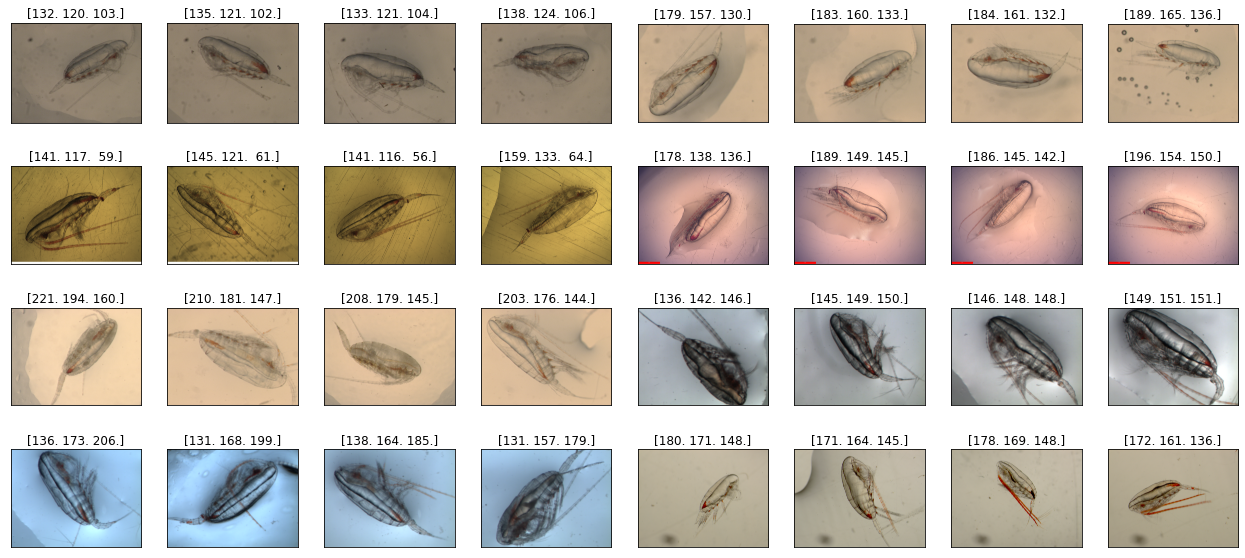

Average original RGB value: 150.14245412939002 , standard deviation: 31.436125424312888
150.14245412939
---
List of RGB medians:  [120.0, 124.0, 121.0, 126.0, 153.0, 160.0, 165.0, 169.0, 114.0, 118.0, 115.0, 123.0, 149.0, 157.0, 154.0, 162.0, 185.0, 185.0, 184.0, 176.0, 163.0, 160.0, 162.0, 166.0, 169.0, 168.0, 164.0, 161.0, 170.0, 166.0, 170.0, 163.0]


In [4]:
imgs_names = os.listdir("imgs_test/dataset2/") # all images to read
imgs_names.sort() # sort images to visualize them in the same order
original_RGB = []
RGB_median_list = [] # prepare a list to save median RGB values of images
RGB_average_list = [] # prepare a list to save median RGB values of images

print("Original images")
w = 16
h = 13
fig = plt.figure(figsize=(22, 10))
columns = 8
rows = 4
for i in range(0, columns*rows): # TODO: add a condition on file types to read (.tiff, .jpg)
    filename = "imgs_test/dataset2/" + imgs_names[i]
    img = io.imread(filename)
    RGB_median_list.append(np.median(img))# stock the RGB median values in a list
    RGB_average_list.append(np.mean(img))# stock the RGB median values in a list
    original_RGB.append(np.mean(img, axis=(0,1)))# stock the RGB calibrated values in a list
    # plot
    fig.add_subplot(rows, columns, i+1)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.title(np.around(np.mean(img, axis=(0,1))))
    plt.imshow(img)
plt.show()
print("Average original RGB value:", np.mean(original_RGB),", standard deviation:", np.std(original_RGB))
print(np.mean(RGB_average_list))
print("---")
print("List of RGB medians: ", RGB_median_list)


Calibrated images, average R,G,B values printed


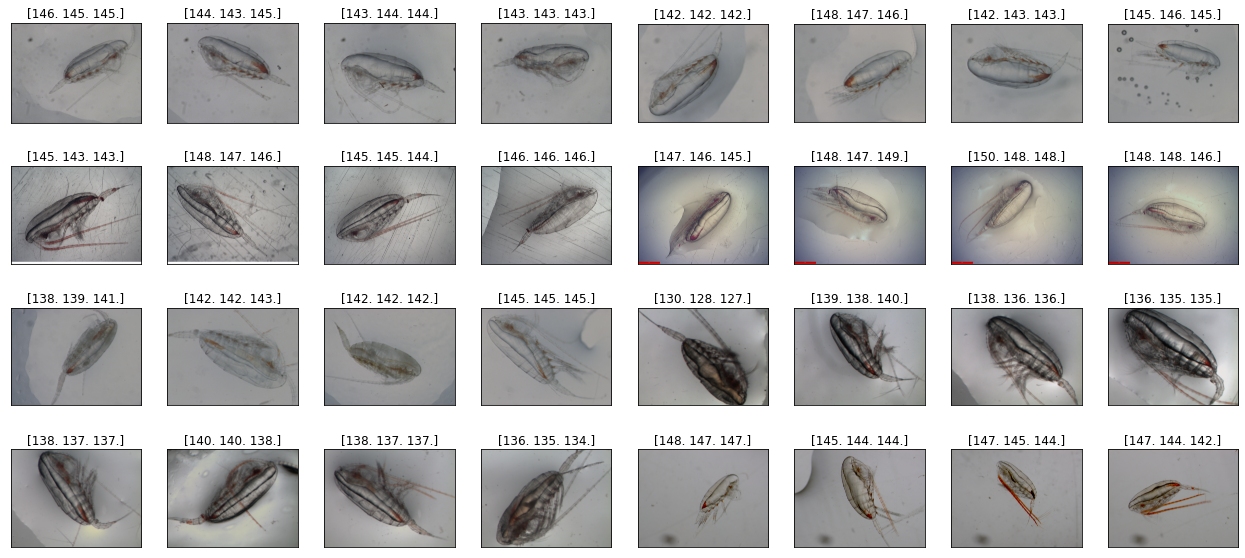

Average final RGB value: 142.58716055288855 , standard deviation: 4.588124582236267


In [6]:
# Grey world calibration

final_RGB = [] #list with final images arrays
print("Calibrated images, average R,G,B values printed")
w = 16
h = 13
fig = plt.figure(figsize=(22, 10))
columns = 8
rows = 4   

for i in range(0, len(imgs_names)):
    filename = "imgs_test/dataset2/" + imgs_names[i] # imgs_list is still the same
    img = io.imread(filename)
    # compute median intensity per channel
    med_r = np.median(img[:,:,0])
    med_g = np.median(img[:,:,1])
    med_b = np.median(img[:,:,2])
    
    # convert all channels to have similar average intensities on the original image and between images
    img_calib = copy.copy(img)
    img_calib[:,:,0] = np.minimum(img[:,:,0] / med_r * np.mean(RGB_average_list), 255)
    img_calib[:,:,1] = np.minimum(img[:,:,1] / med_g * np.mean(RGB_average_list), 255)
    img_calib[:,:,2] = np.minimum(img[:,:,2] / med_b * np.mean(RGB_average_list), 255)
    final_RGB.append(np.mean(img_calib, axis=(0,1))) # stock the RGB calibrated values in a list) # stock the RGB calibrated values in a list
    # NB: check that this stays in [0,255] = [black, white]
    
    # plot
    fig.add_subplot(rows, columns, i+1)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.title(np.around(np.mean(img_calib, axis=(0,1))))
    plt.imshow(img_calib)
    
    #save
    io.imsave("imgs_processed/test3/dataset2_calibrated/" + imgs_names[i] + "_calibrated.jpg", img_calib)
plt.show()
print("Average final RGB value:", np.mean(final_RGB), ", standard deviation:", np.std(final_RGB))

</br>

**The result seems quite ok (standard deviation has diminuished a lot), but there is still a large variability accross images. Note that the resolution vary across images (not the same number of pixels) and that the red color bar for images 13 to 16 will be a problem.**

## Deconvolution matrix

In [7]:
rgb_from_stains = np.array([
    # RDG value from literature 
    [1.        ,  0.68396032,  0.6330574],
    # White
    [1, 1, 1],
    # Placeholder for third color
    [0,0,0]])
# Calculate residuals = normalize the OD matrix: 
rgb_from_stains[2, :] = np.cross(rgb_from_stains[0, :], rgb_from_stains[1, :])
display("Normalized OD matrix :", rgb_from_stains)

# Calculate matrix inverse with linalg.inv :
stains_from_rgb = linalg.inv(rgb_from_stains)
display("Inversed OD matrix = color deconvolution matrix:", stains_from_rgb)

'Normalized OD matrix :'

array([[ 1.        ,  0.68396032,  0.6330574 ],
       [ 1.        ,  1.        ,  1.        ],
       [ 0.05090292, -0.3669426 ,  0.31603968]])

'Inversed OD matrix = color deconvolution matrix:'

array([[ 2.88033482, -1.89126227,  0.21467241],
       [-1.11815879,  1.19693125, -1.54750362],
       [-1.76217603,  1.69433103,  1.3328312 ]])

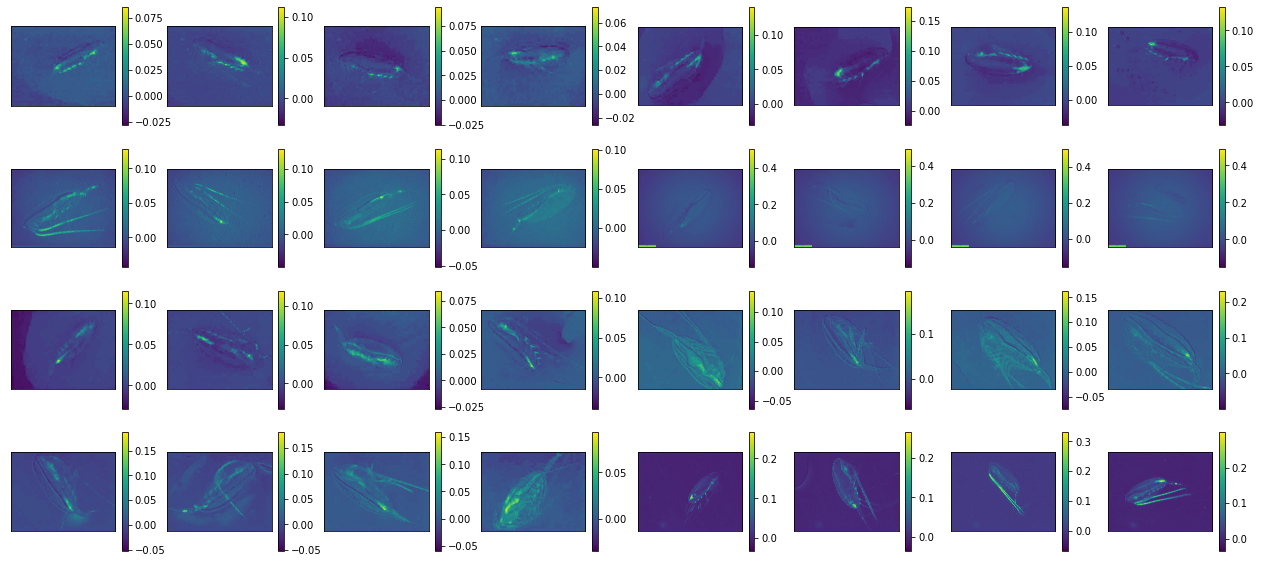

min = -0.154346608192969 , max = 0.5022865977475277


In [8]:
imgs_calib_list = os.listdir("imgs_processed/test3/dataset2_calibrated") # for now, we are taking calibrated images with the first calibration method 
imgs_calib_list.sort() # sort images to visualize them in the same order
asta_OD_min = []
asta_OD_max = []
asta_OD_imgs_list = []

w = 16
h = 13
fig = plt.figure(figsize=(22, 10))
columns = 8
rows = 4
for i in range(0, len(imgs_calib_list)):
    filename_calibrated = "imgs_processed/test3/dataset2_calibrated/" + imgs_calib_list[i]
    img_calib = io.imread(filename_calibrated)
    stains = separate_stains(img_calib, stains_from_rgb) # Extract stains 
    red = -stains[...,0]# RGB to stain color space conversion (sickit image)
    asta_OD_imgs_list.append(red)
    asta_OD_min.append(np.min(red))
    asta_OD_max.append(np.max(red))
    
    # Plot
    fig.add_subplot(rows, columns, i+1)
    #plt.title(imgs_names[i])
    plt.xticks([], [])
    plt.yticks([], [])
    low, high = np.quantile(red, (.0, 1))
    plt.imshow(red, vmin=low, vmax = high)
    plt.colorbar()
plt.show()

print("min =", np.min(asta_OD_min), ", max =", np.max(asta_OD_max))


</br>

**The result seems quite ok (standard deviation has diminuished a lot), but there is still a large variability accross images. Note that the resolution vary across images (not the same number of pixels) and that the red scale bar for images 13 to 16 will be a problem.**

Normalised astaxanthin OD levels between 0 and 1


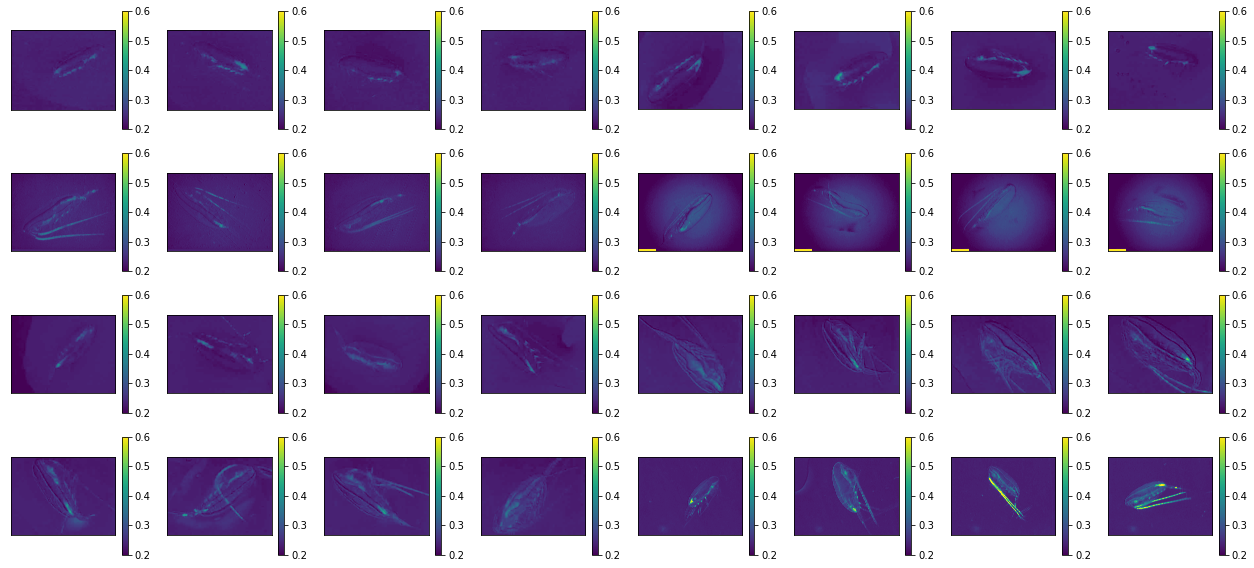

/home/lvilgrain/miniconda3/envs/pym/lib/python3.9/site-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [9]:
imgs_norm_list = [ ]

print("Normalised astaxanthin OD levels between 0 and 1")
w = 16
h = 13
fig = plt.figure(figsize=(22, 10))
columns = 8
rows = 4
for i in range(0, len(imgs_calib_list)):
    img = asta_OD_imgs_list[i]
    # threshold using intensities histogramm on the image 
    img_norm = (img + np.absolute(np.min(asta_OD_min))) / (np.max(asta_OD_max) + np.absolute(np.min(asta_OD_min)))
    imgs_norm_list.append(img_norm)
    
    # Plot
    fig.add_subplot(rows, columns, i+1)
    plt.xticks([], [])
    plt.yticks([], [])
    #low, high = np.quantile(img_norm, (.0, 1))
    plt.imshow(img_norm, vmin=0.2, vmax = 0.6)
    plt.colorbar()
    
plt.show()
print("min =", np.min(imgs_norm_list), "max =", np.max(imgs_norm_list))

</br>

**The error message is probably linked to the variation of pixel size : the array can not contain elements with variable size.**

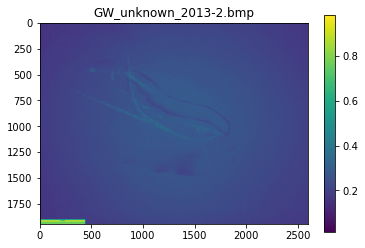

In [10]:
plt.title(imgs_names[13])
low, high = np.quantile(imgs_norm_list[13], (.0, 1))
plt.imshow(imgs_norm_list[13], vmin=low, vmax = high)
plt.colorbar()
plt.show()

</br>

**We can see that the red scale bar is a problem, we really need to find a way to crop edges for those cases or if multple copepods are present on the image**

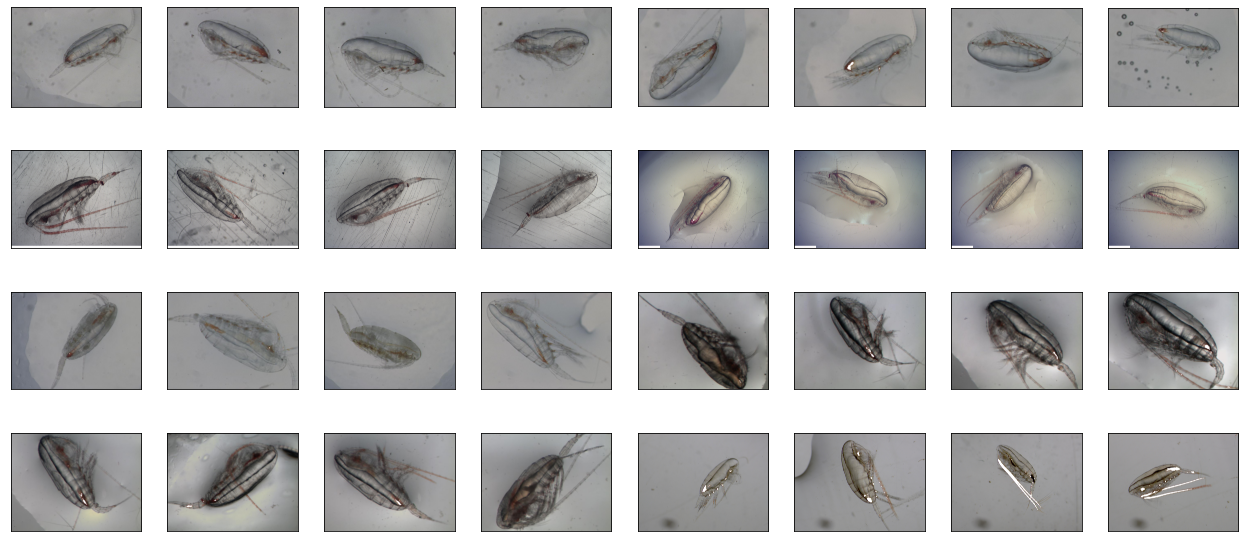

In [11]:
w = 16
h = 13
fig = plt.figure(figsize=(22, 10))
columns = 8
rows = 4
for i in range(0, len(imgs_norm_list)):
    filename_calibrated = "imgs_processed/test3/dataset2_calibrated/" + imgs_calib_list[i]
    img_calib = io.imread(filename_calibrated)
    
    red =  imgs_norm_list[i]
    thr = 0.40
    red_mask = red > thr # red mask :
    
    # Show on original image
    img_highlight = copy.copy(img_calib)
    img_highlight[:,:,0][red_mask] = 255
    img_highlight[:,:,1][red_mask] = 255
    img_highlight[:,:,2][red_mask] = 255
    io.imsave("imgs_processed/test3/dataset2_calibrated/" + imgs_names[i] + "_redpix.jpg", img_highlight)
    
    # Plot
    fig.add_subplot(rows, columns, i+1)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.imshow(img_highlight)
plt.show()

</br>

**Of course, segmentation is not efficient because the threshold is not good (variable according to initial dataset), and espcially with the red scale bar**